In [12]:
"""
@author: Crazy Trader
Trading Hours (HKT Timezone) Mon - Fri: 
    HSI Derivatives(Day Session)    : 09:15 - 12:00, 13:00 - 16:30
                   (Night Session)  : 17:15 - 01:00
    HK Equities    (Auction Session): 09:00 - 09:30
                   (Day Session)    : 09:30 - 12:00, 13:00 - 16:08
    US Equities                     : 22:30 - 05:00
    Forex                           : 00:00 - 23:59
Restrictions:
    Trading must be in trading hours
    Trading must be in sufficnet cash
    Option Strike Price is in step of 200
    Backtest would be stopped with restriction
Assumptions:
    Open/Close Rate means Bid/Ask for FX, Close for EQ, and Strike for Options
    Option price based on Interest rate is 0.15% and dividend yield is 4.24%, per year
    no overnight fee incurred
Operations:
    Long with Ask Price
    Short with Bid Price
"""

In [10]:
from pylab import *
rcParams['figure.figsize'] = (39, 18)

In [2]:
#%% Library & Initialize Dataset and Backtesting Platform
from functions import *
dataset = {}
dataset['HSI']      = 'EQ'       # Close, Volume
dataset['PUT']      = 'Custom'   # requires functions
dataset['CALL']     = 'Custom'   # requires functions
dataset['VHSI']     = 'Vol'      # Close
dataset['VIX']      = 'Vol'      # Close
dataset['USDHKD']   = 'FX'       # Bid, Ask
dataset['XAUHKD']   = 'FX'       # Bid, Ask
dataset['HKDTRY']   = 'FX'       # Bid, Ask
dataset['USDTRY']   = 'FX'       # Bid, Ask
dataset['XRPUSD']   = 'FX'       # Bid, Ask
# load dataset and setup initial cash + default handling fee
platform = backtest(10000000, 100, dataset)

Dataset Range: from 2018-08-07 09:31:00 to 2018-11-08 16:01:00


In [12]:
#%% Backtest Params
start   = '2018-09-01 00:00:00'                             # initialize start date
end     = '2018-11-08 00:00:00'                             # initialize start date
mask = (platform.quote['USDHKD'].index > start) & (platform.quote['USDHKD'].index <= end)
backtestperiod = platform.quote['USDHKD'].loc[mask]
platform.initportfolio(10000000, 100)                       # reset initial cash + default handling fee

In [14]:
# start looping every 1 minute
print ('Start Backtesting...')
prev = None
for time, reference in backtestperiod.iterrows():
    """ 
    Read-Only Params:
    platform.quote['HSI'].loc[time].Close
    platform.quote['HSI'].loc[time].Volume
    platform.quote['VIX'].loc[time].Close
    platform.quote['VHSI'].loc[time].Close
    platform.quote['XAUHKD'].loc[time].Bid
    platform.quote['XAUHKD'].loc[time].Ask
    platform.quote['USDTRY'].loc[time].Bid
    platform.quote['USDTRY'].loc[time].Ask
    platform.quote['XRPUSD'].loc[time].Bid
    platform.quote['XRPUSD'].loc[time].Ask
    
    Paper Trade Methods:
    trade(time, 'XRPUSD', 'LONG',  100000)          # LONG FX Order
    trade(time, 'XRPUSD', 'CLOSE')                  # CLOSE FX LONG Order
    trade(time, 'XRPUSD', 'SHORT', 100000)          # SHORT FX Order
    trade(time, 'XRPUSD', 'CLOSE')                  # CLOSE FX SHORT Order
    trade(time, 'HSI',    'SHORT', 10)              # LONG EQ Order
    trade(time, 'HSI',    'CLOSE')                  # CLOSE EQ LONG Order
    trade(time, 'CALL',   'SHORT', 100, 26000, 8)   # SHORT EQ CALL Option
    trade(time, 'CALL',   'CLOSE')                  # CLOSE EQ CALL Option
    
    Other Methods:
    platform.portfolio['cash']                      # Available Cash
    platform.has_pos('HSI')                         # Check if trading log already ahs HSI positio
    """ 
    #Examples: 
    if not prev:                                    # skip first loop to record the time
        prev = time
        print (time, 'Avl.Cash:', platform.portfolio['cash'])
        continue
    # Check if EQ market is opened
    if platform.is_eqmktopen(time): 
        # Long EQ conditions
        if (
                platform.quote['VHSI'].loc[time].Close - platform.quote['VHSI'].loc[prev].Close >= 1 
             or platform.quote['VIX'].loc[time].Close - platform.quote['VIX'].loc[prev].Close >= 1
             ):
            if not platform.has_pos('HSI'):                     # Check if no position exists
                platform.trade(time, 'HSI',  'SHORT', 100)
                option_strike      = (int(platform.quote['HSI'].loc[time].Close / 200) - 2) * 200
                platform.trade(time, 'CALL', 'LONG',  20, option_strike, time.month)
        # Close EQ conditions
        if (
                platform.quote['VHSI'].loc[prev].Close - platform.quote['VHSI'].loc[time].Close >= 1 
             or platform.quote['VIX'].loc[prev].Close - platform.quote['VIX'].loc[time].Close >= 1
             ):
            if platform.has_pos('HSI'):                         # Check if position exists
                platform.trade(time, 'HSI',  'CLOSE')
                platform.trade(time, 'CALL', 'CLOSE')
    # Check if FX and Crypto markets are opened             
    if platform.is_fxmktopen(time):  
        # Long Crypto conditions
        if platform.quote['VIX'].loc[time].Close - platform.quote['VIX'].loc[prev].Close >= 1:
            if not platform.has_pos('XRPUSD'):                  # Check if no position exists
                platform.trade(time, 'XRPUSD', 'SHORT', 100)
        # Close Crypto conditions
        if platform.quote['VIX'].loc[prev].Close - platform.quote['VIX'].loc[time].Close >= 1:
            if platform.has_pos('XRPUSD'):                      # Check if position exists
                platform.trade(time, 'XRPUSD', 'CLOSE')
        # Long FX conditions
        if time.month == 9:
            if not platform.has_pos('USDTRY'):                  # Check if no position exists
                platform.trade(time, 'USDTRY', 'SHORT', 5000000)
        # Close FX conditions                      
        if time.month == 10 and time.day == 31:
            if platform.has_pos('USDTRY'):                      # Check if position exists
                platform.trade(time, 'USDTRY', 'CLOSE')
                
    prev = time                                                 # Save this time for next loop
    
    ### ADD YOUR CODE HERE ###
    
    ### ADD YOUR CODE HERE ###
    
    # Update position info once a day: Unrealized, realized P&L
    if time.timestamp() % 86400 == 0:
        platform.updatepos(time)

Start Backtesting...
2018-09-01 00:01:00 Avl.Cash: 10000000
2018-09-01 00:02:00 Avl.Cash: 4051492.0 USDTRY SHORT 5000000 @ 6.6
2018-09-14 13:02:00 Avl.Cash: 1333892.0 HSI SHORT 100 @ 27175.0
2018-09-14 13:02:00 Avl.Cash: 1318436.0 CALL ( 26600 9 ) LONG 20 @ 767.83
2018-09-15 00:02:00 Avl.Cash: 1318118.0 XRPUSD SHORT 100 @ 0.28
2018-10-05 20:32:00 Avl.Cash: 4098218.0 HSI CLOSE 100 @ 26544.0
2018-10-05 20:32:00 Avl.Cash: 4097950.0 XRPUSD CLOSE 100 @ 0.51
2018-10-05 20:33:00 Avl.Cash: 1441050.0 HSI SHORT 100 @ 26568.0
2018-10-05 20:33:00 Avl.Cash: 1423468.0 CALL ( 26000 10 ) LONG 20 @ 874.1
2018-10-05 20:33:00 Avl.Cash: 1422966.0 XRPUSD SHORT 100 @ 0.51
2018-10-12 02:50:00 Avl.Cash: 1423154.0 XRPUSD CLOSE 100 @ 0.4
2018-10-12 15:16:00 Avl.Cash: 4160654.0 HSI CLOSE 100 @ 25758.0
2018-10-12 15:16:00 Avl.Cash: 4167542.0 CALL CLOSE 20 @ 359.41
2018-10-15 09:31:00 Avl.Cash: 1610442.0 HSI SHORT 100 @ 25570.0
2018-10-15 09:31:00 Avl.Cash: 1594871.0 CALL ( 25000 10 ) LONG 20 @ 773.56
2018-10-23 1

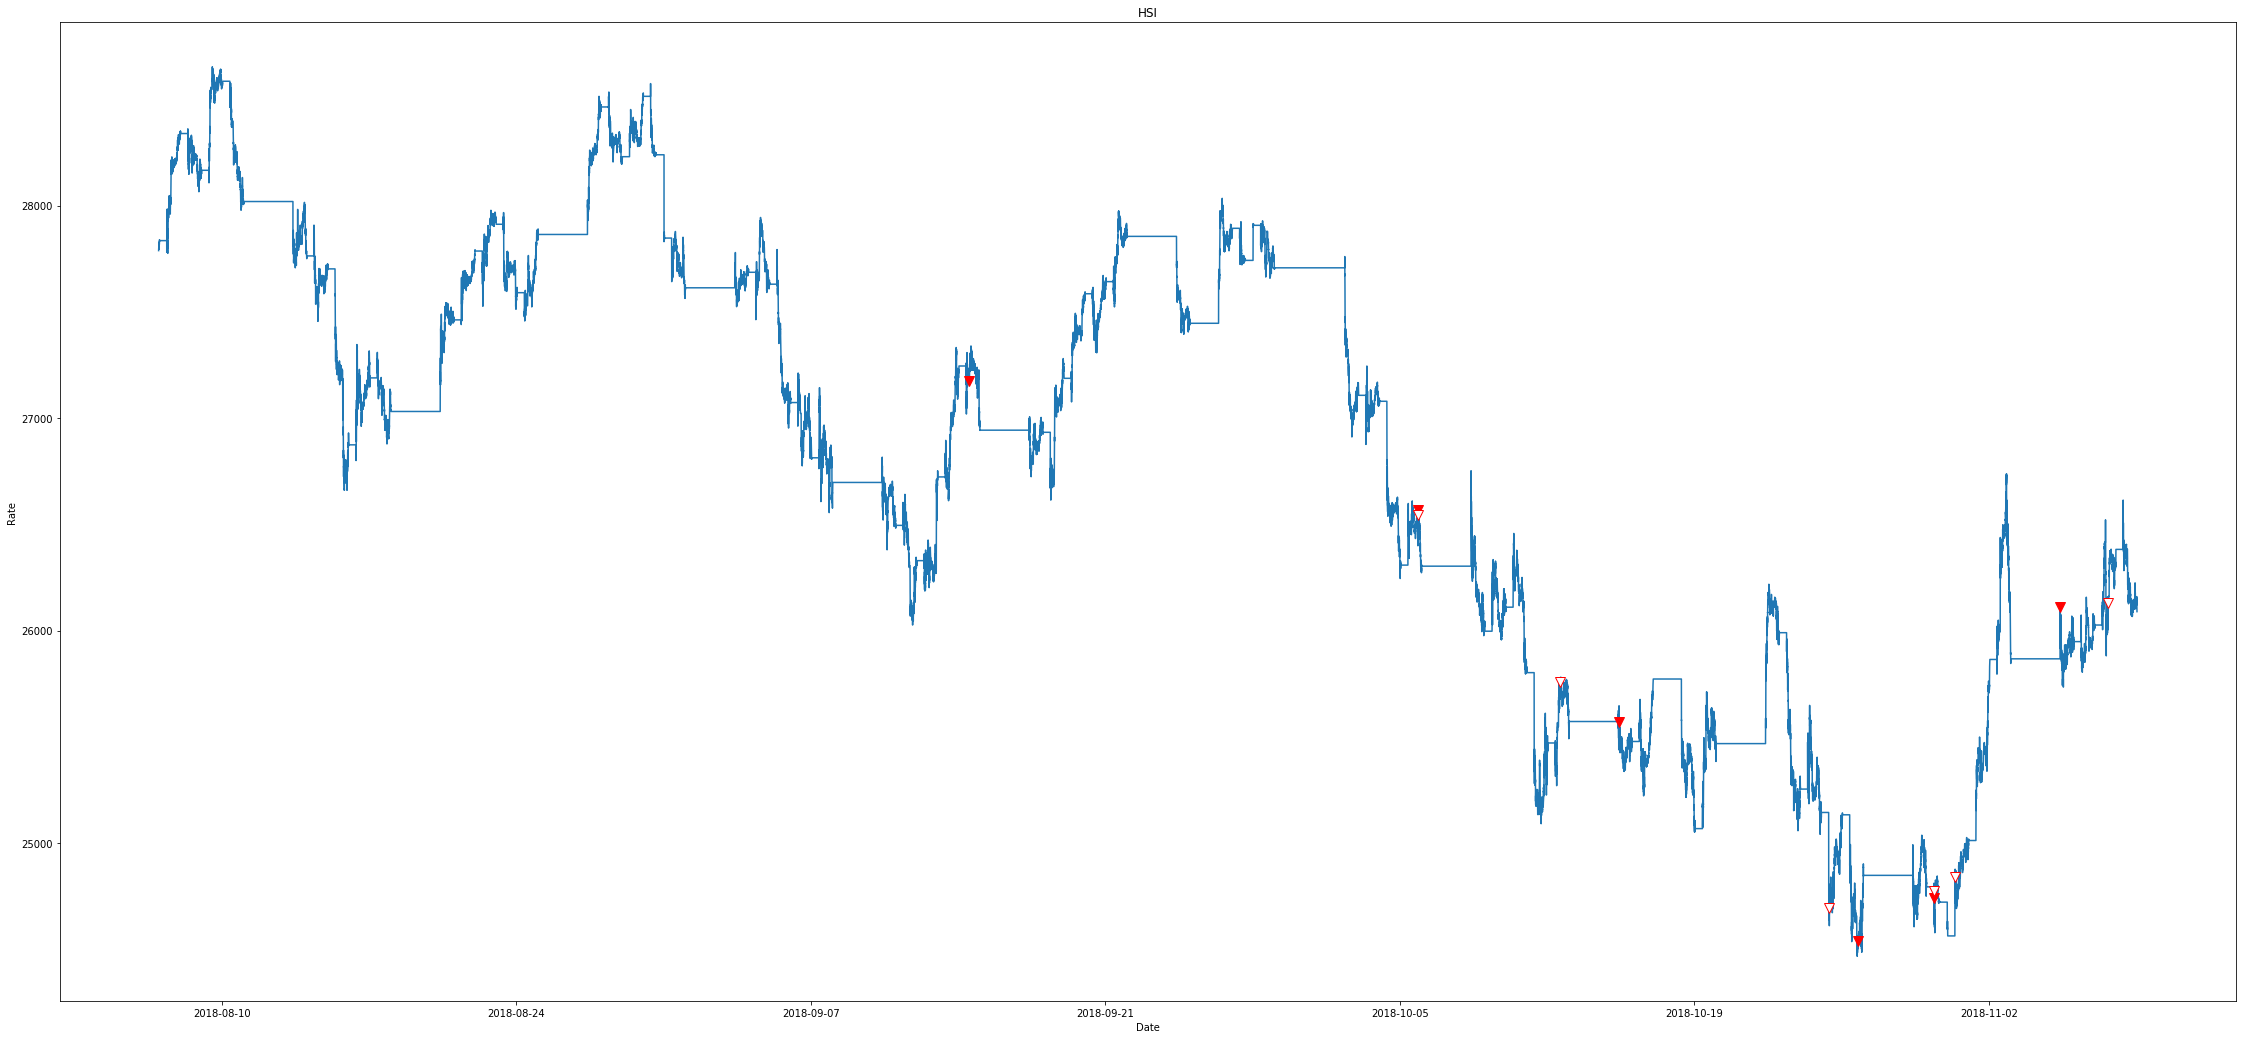

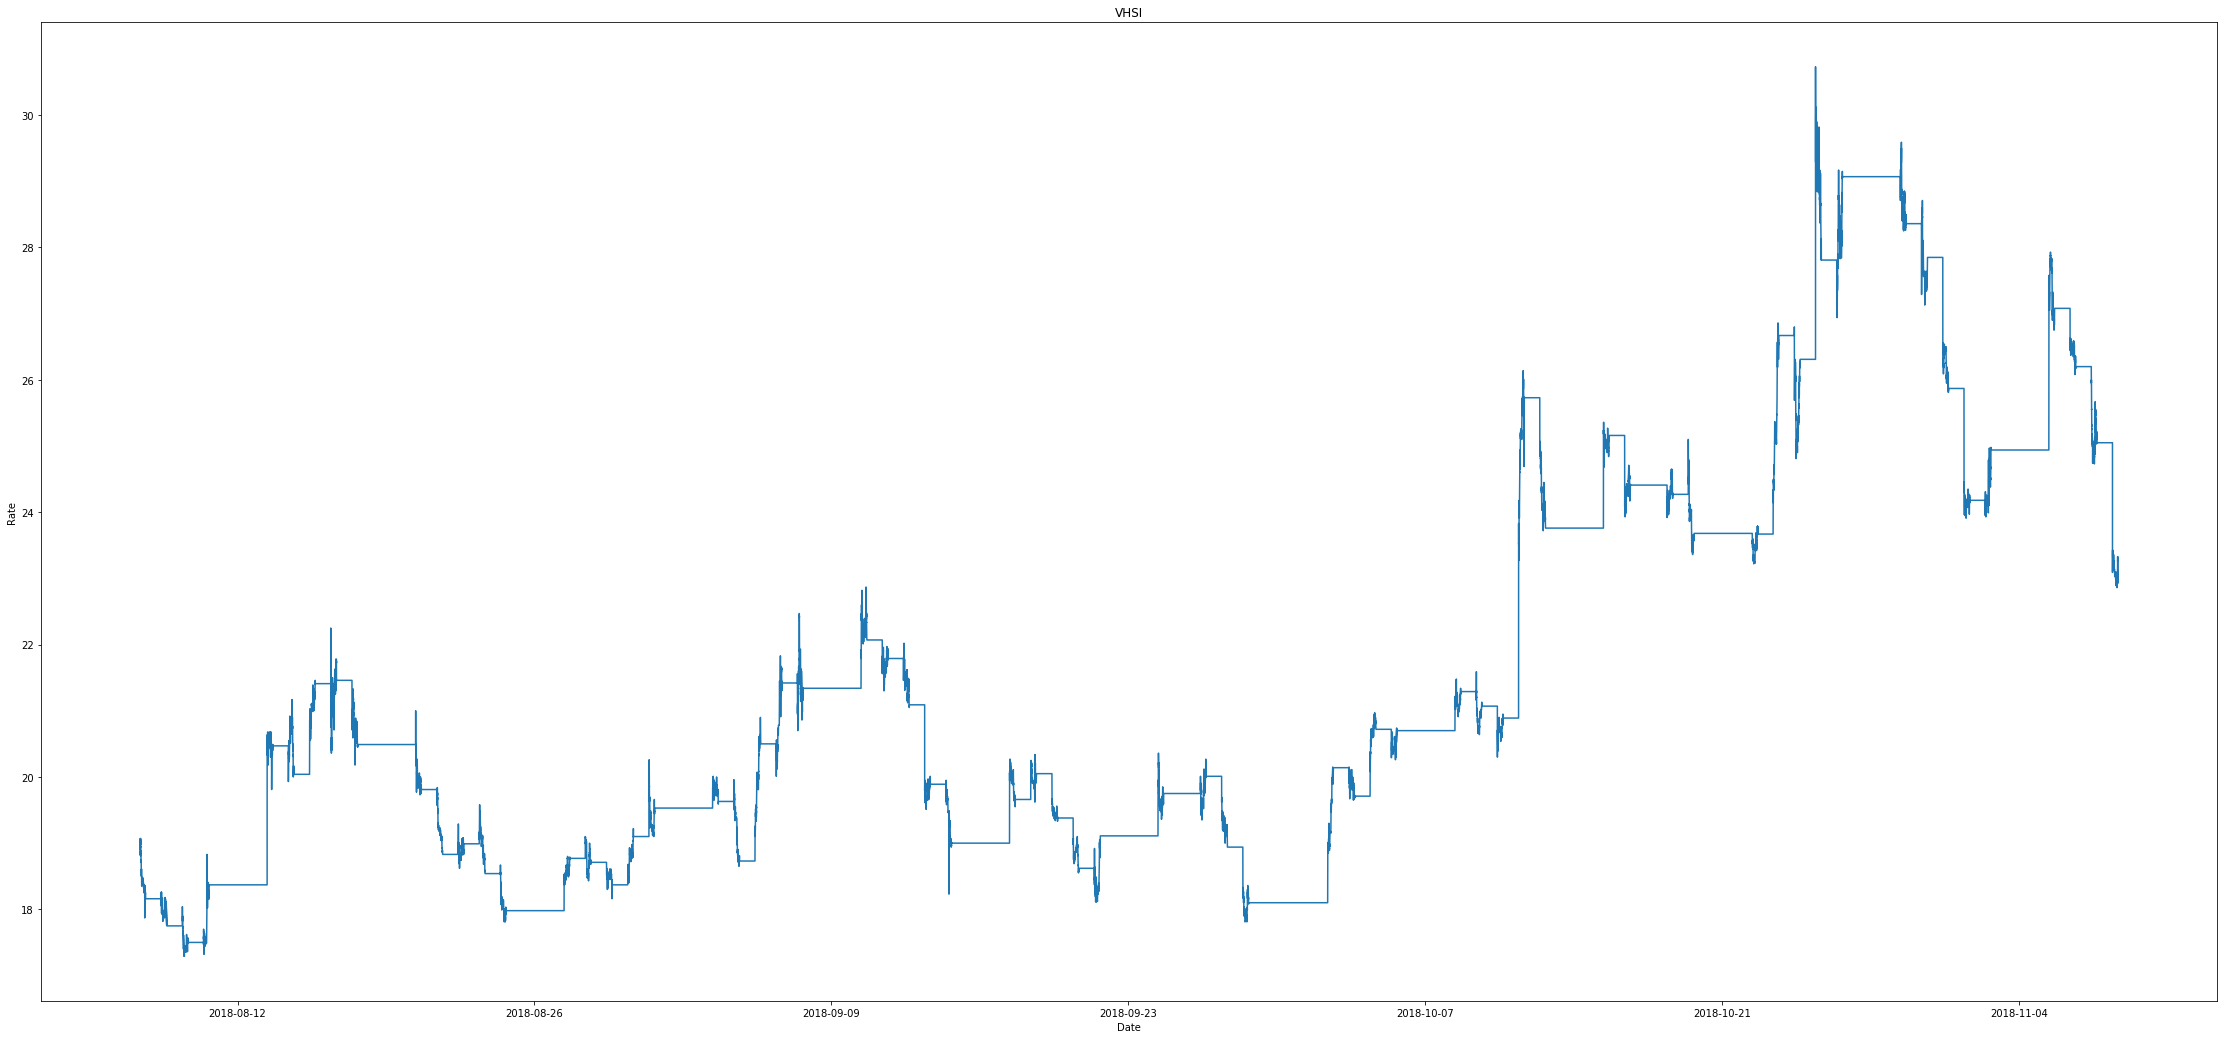

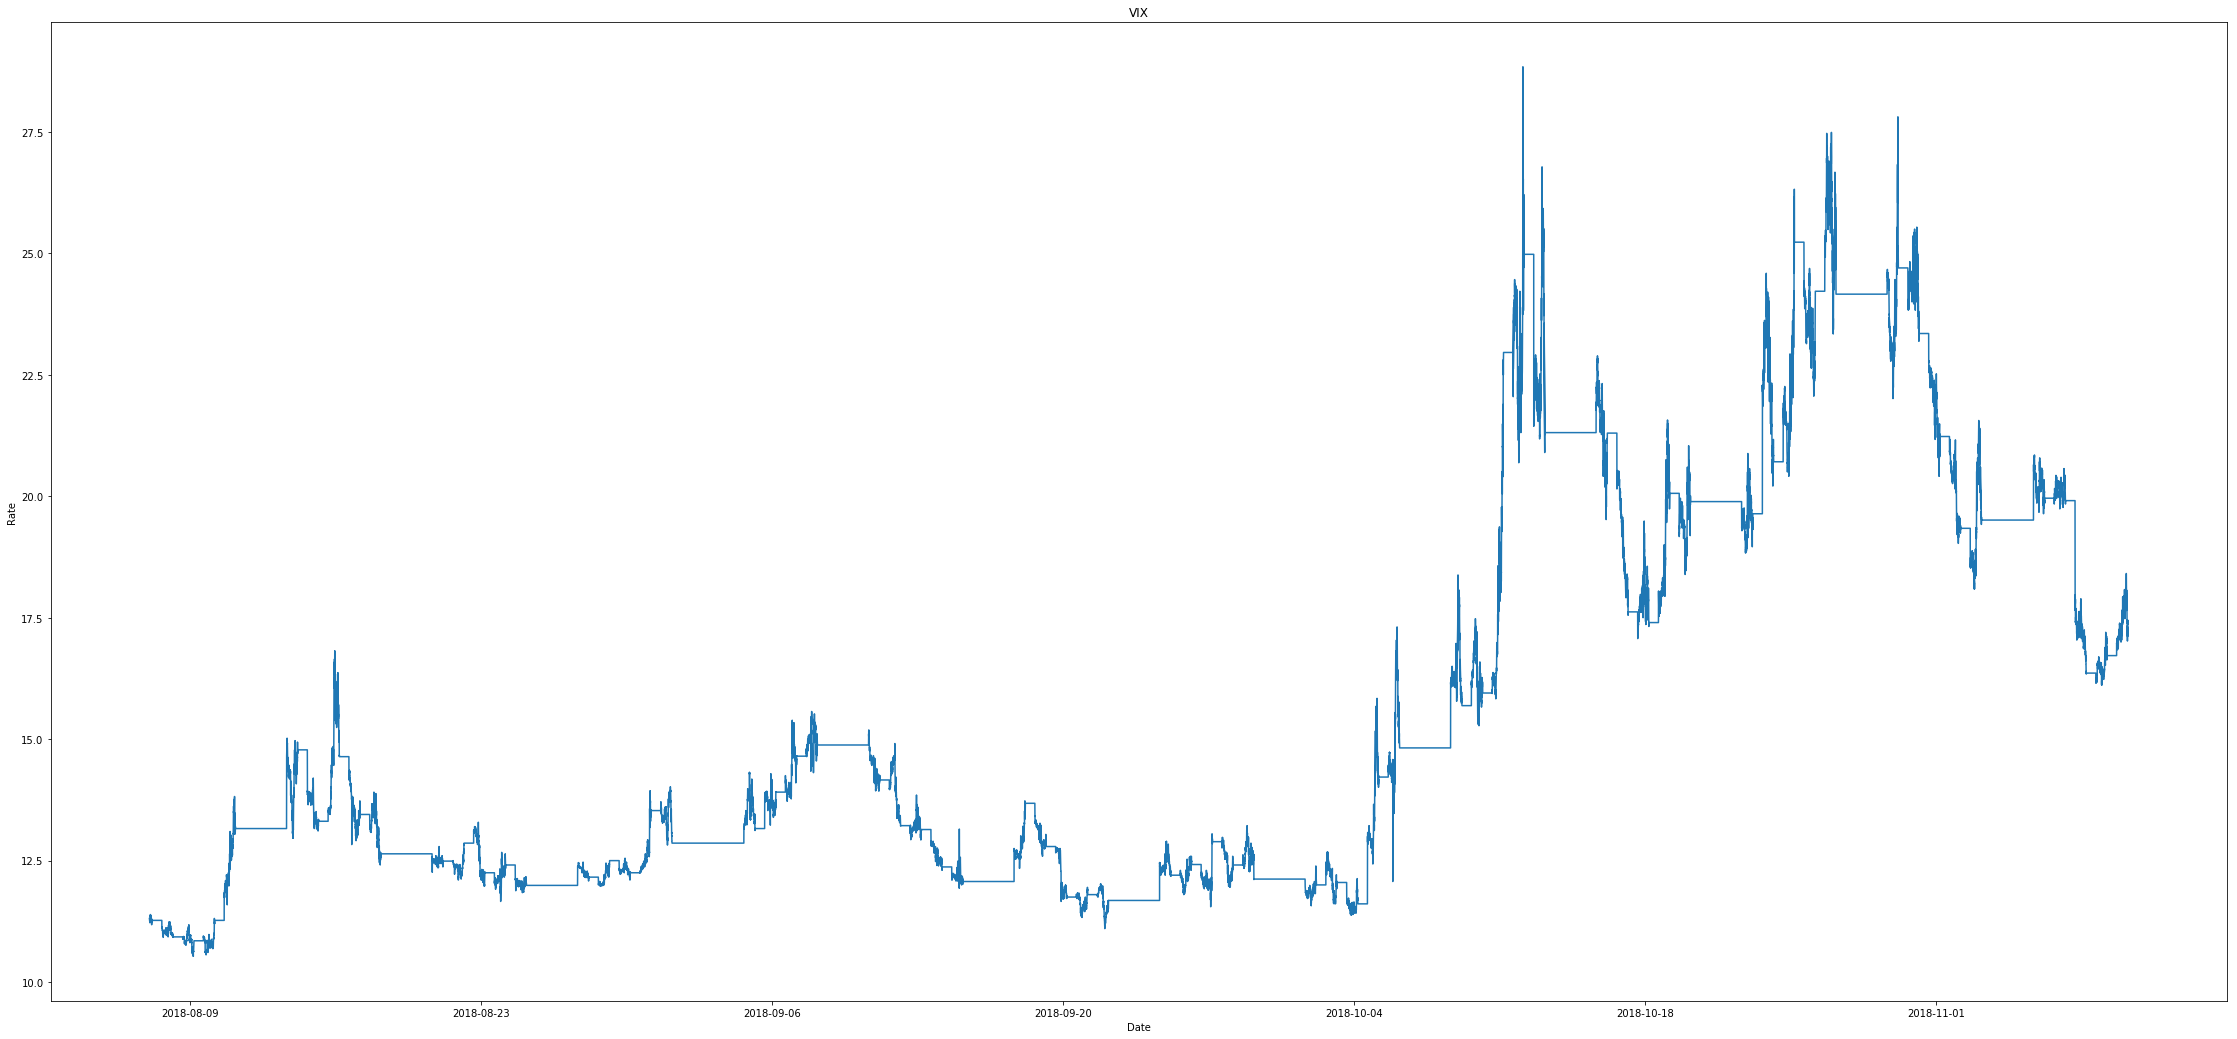

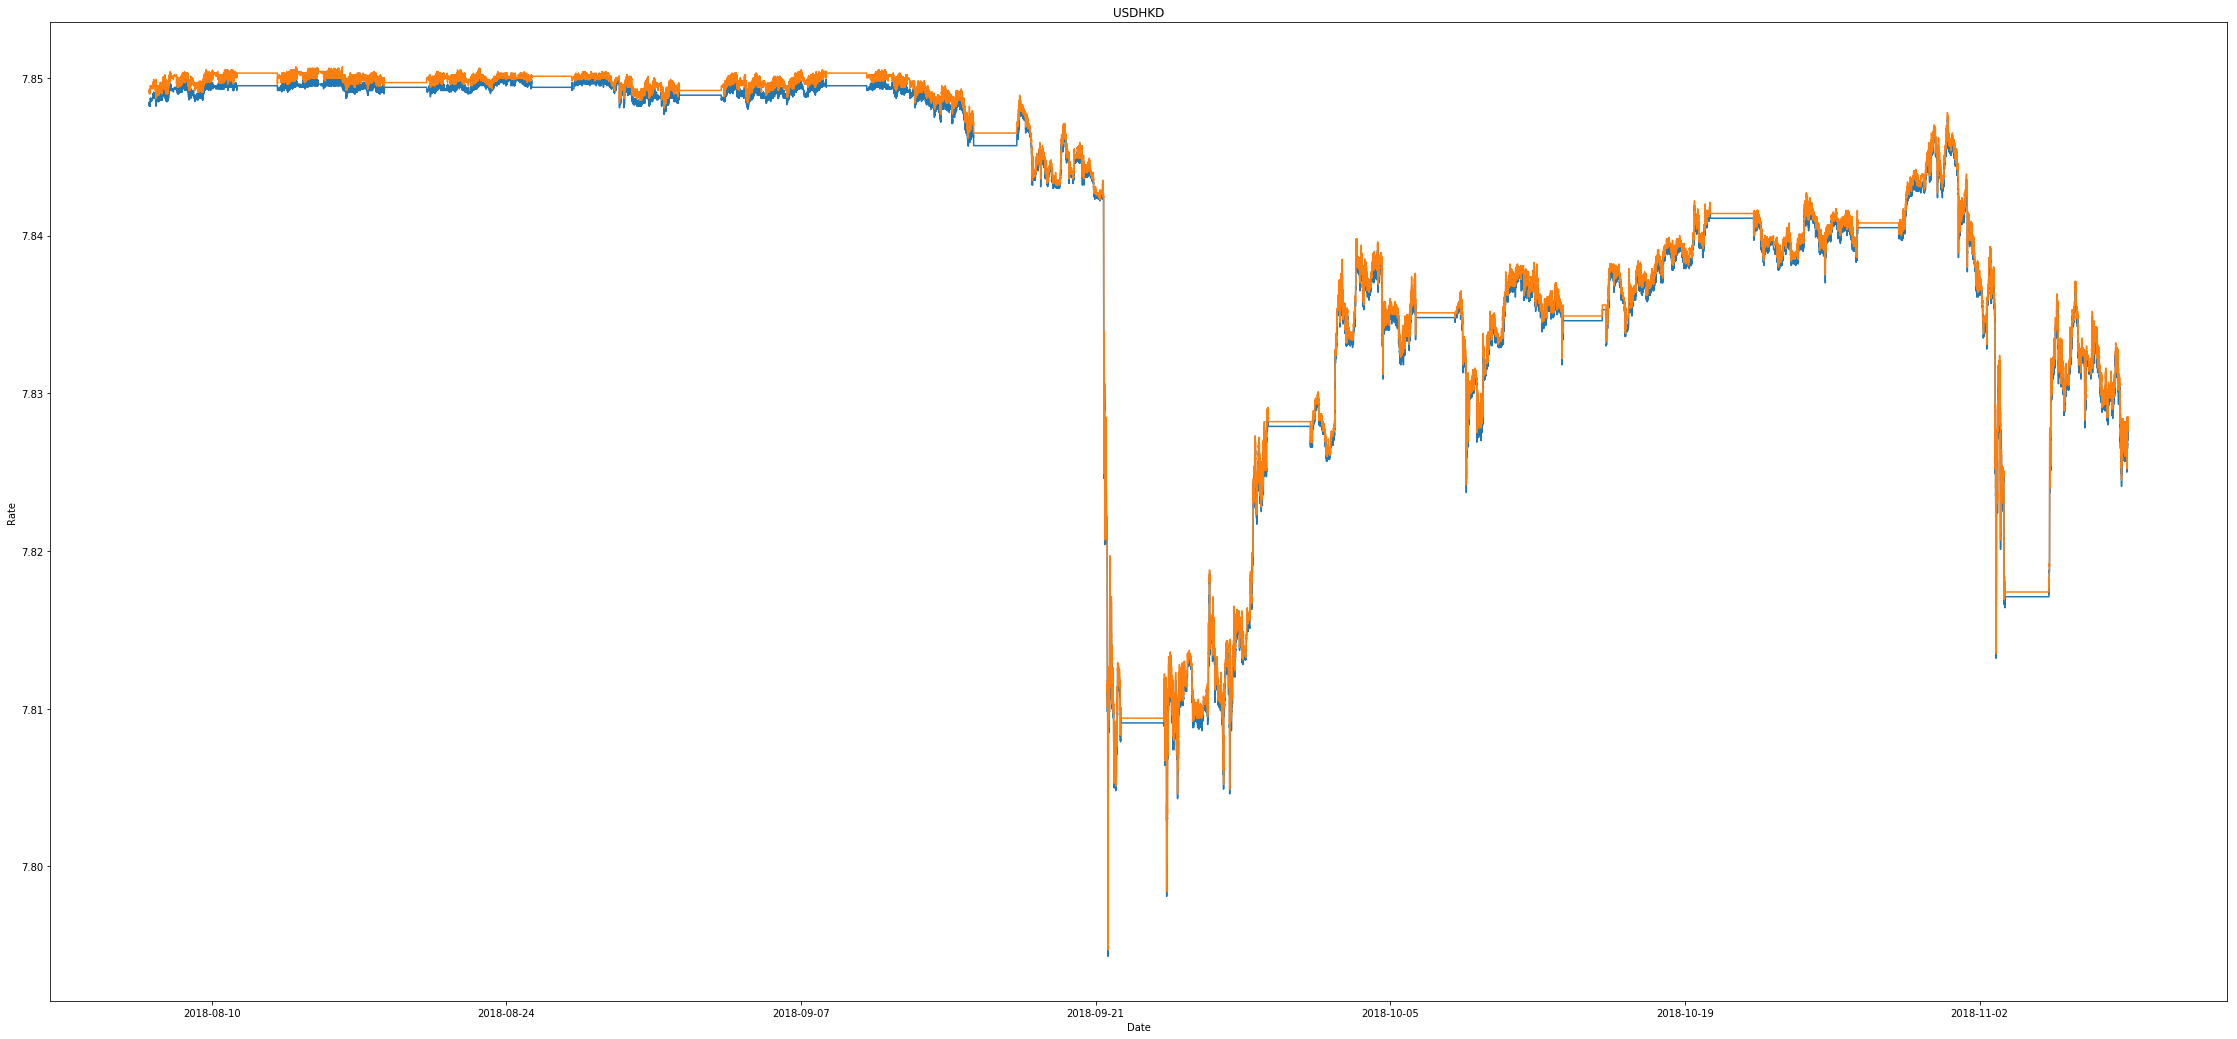

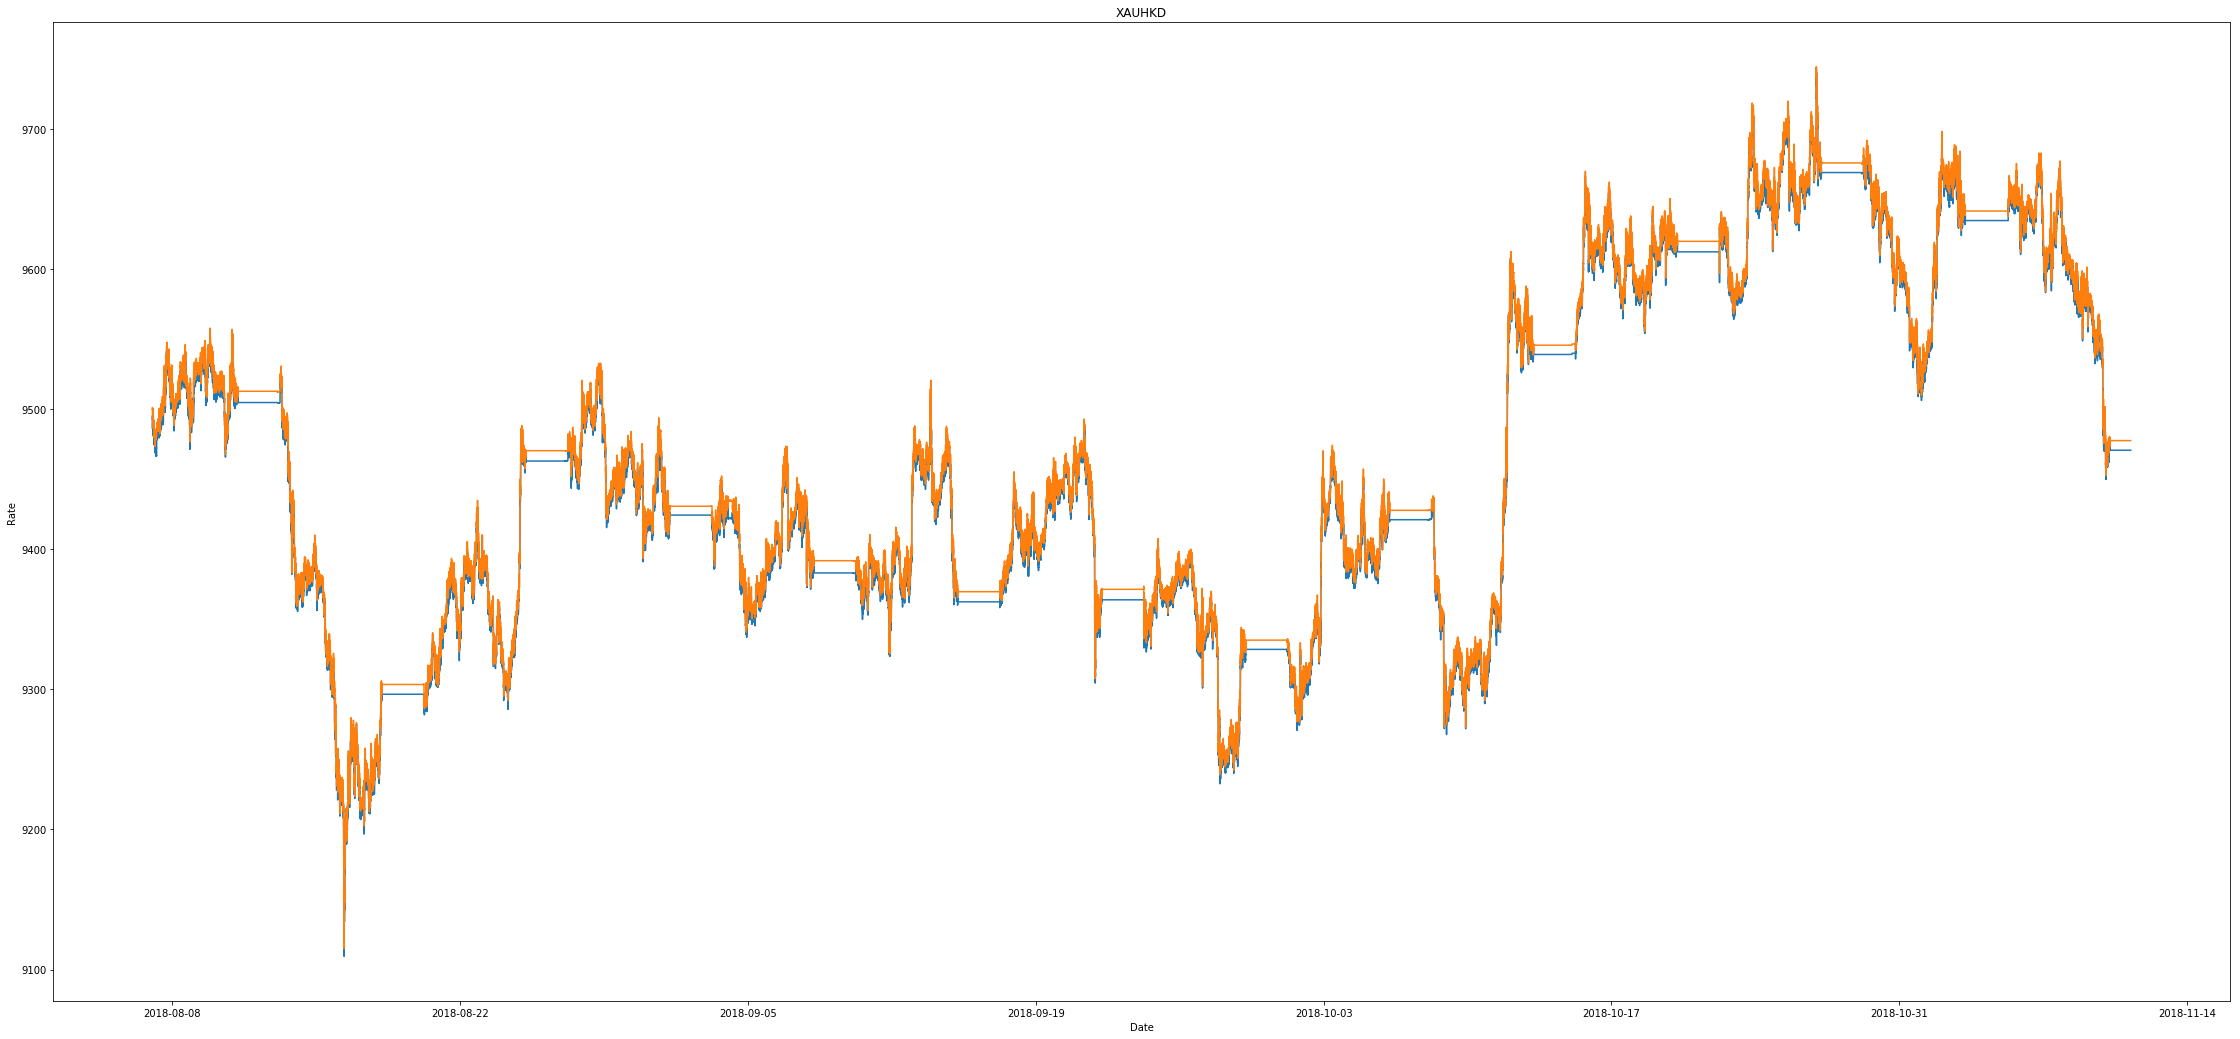

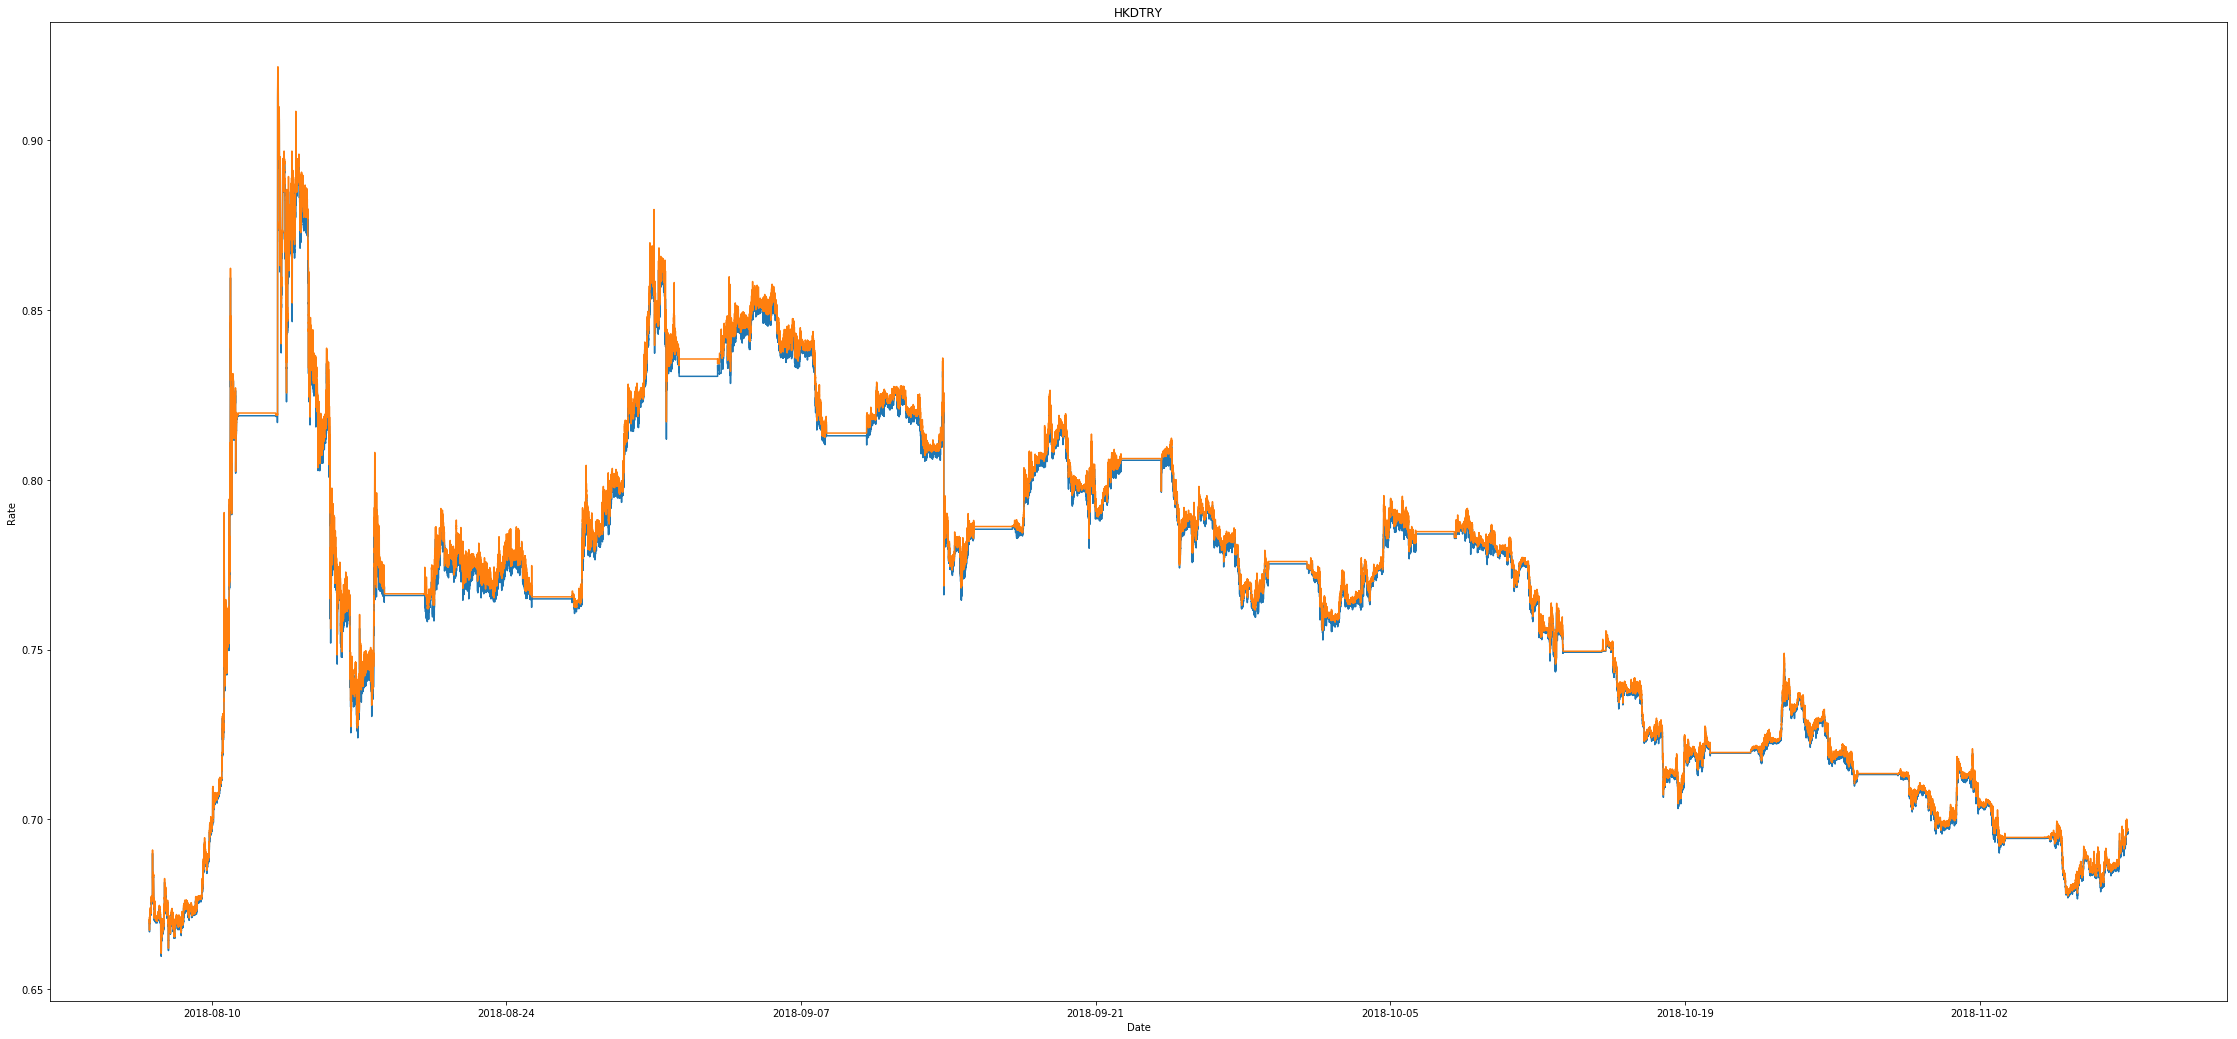

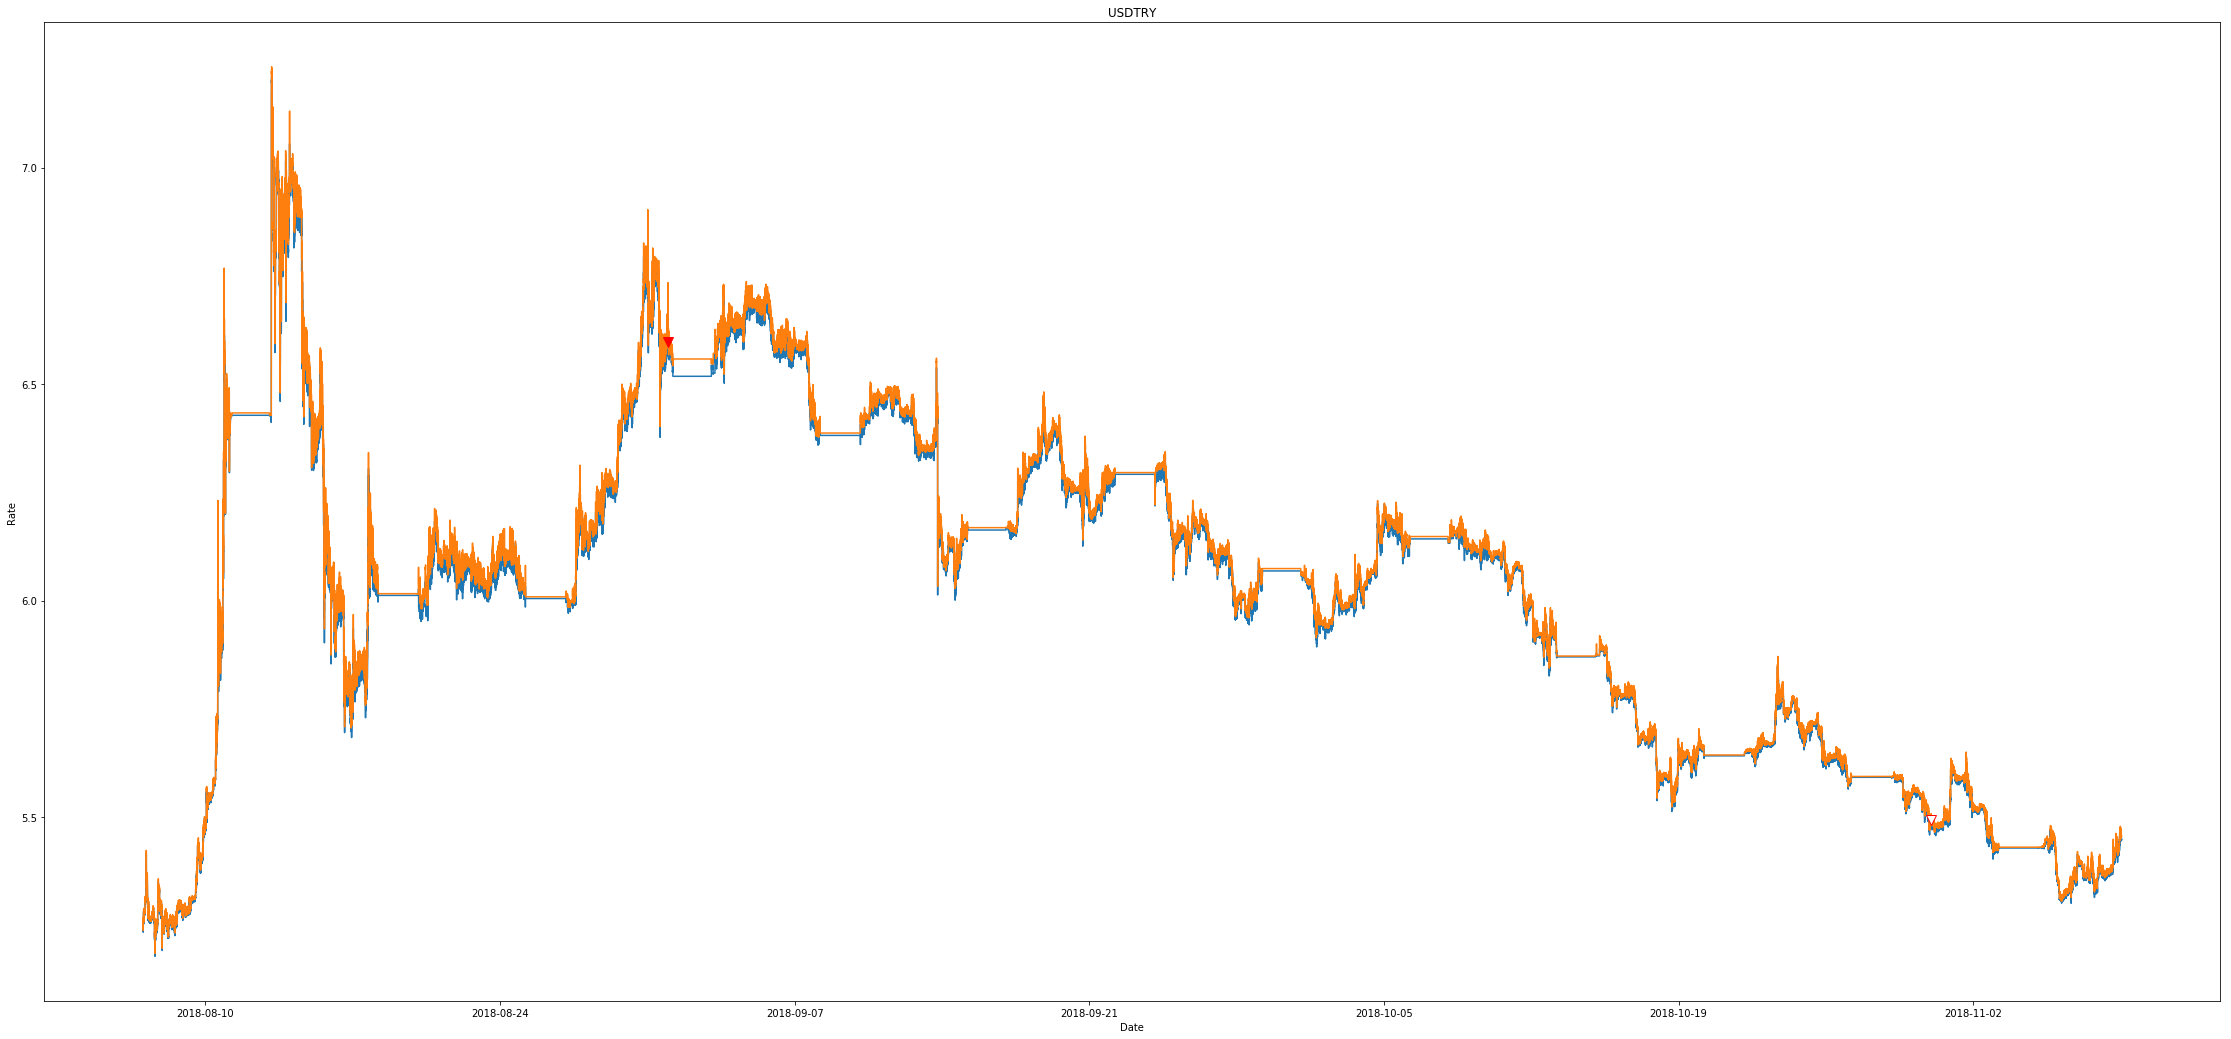

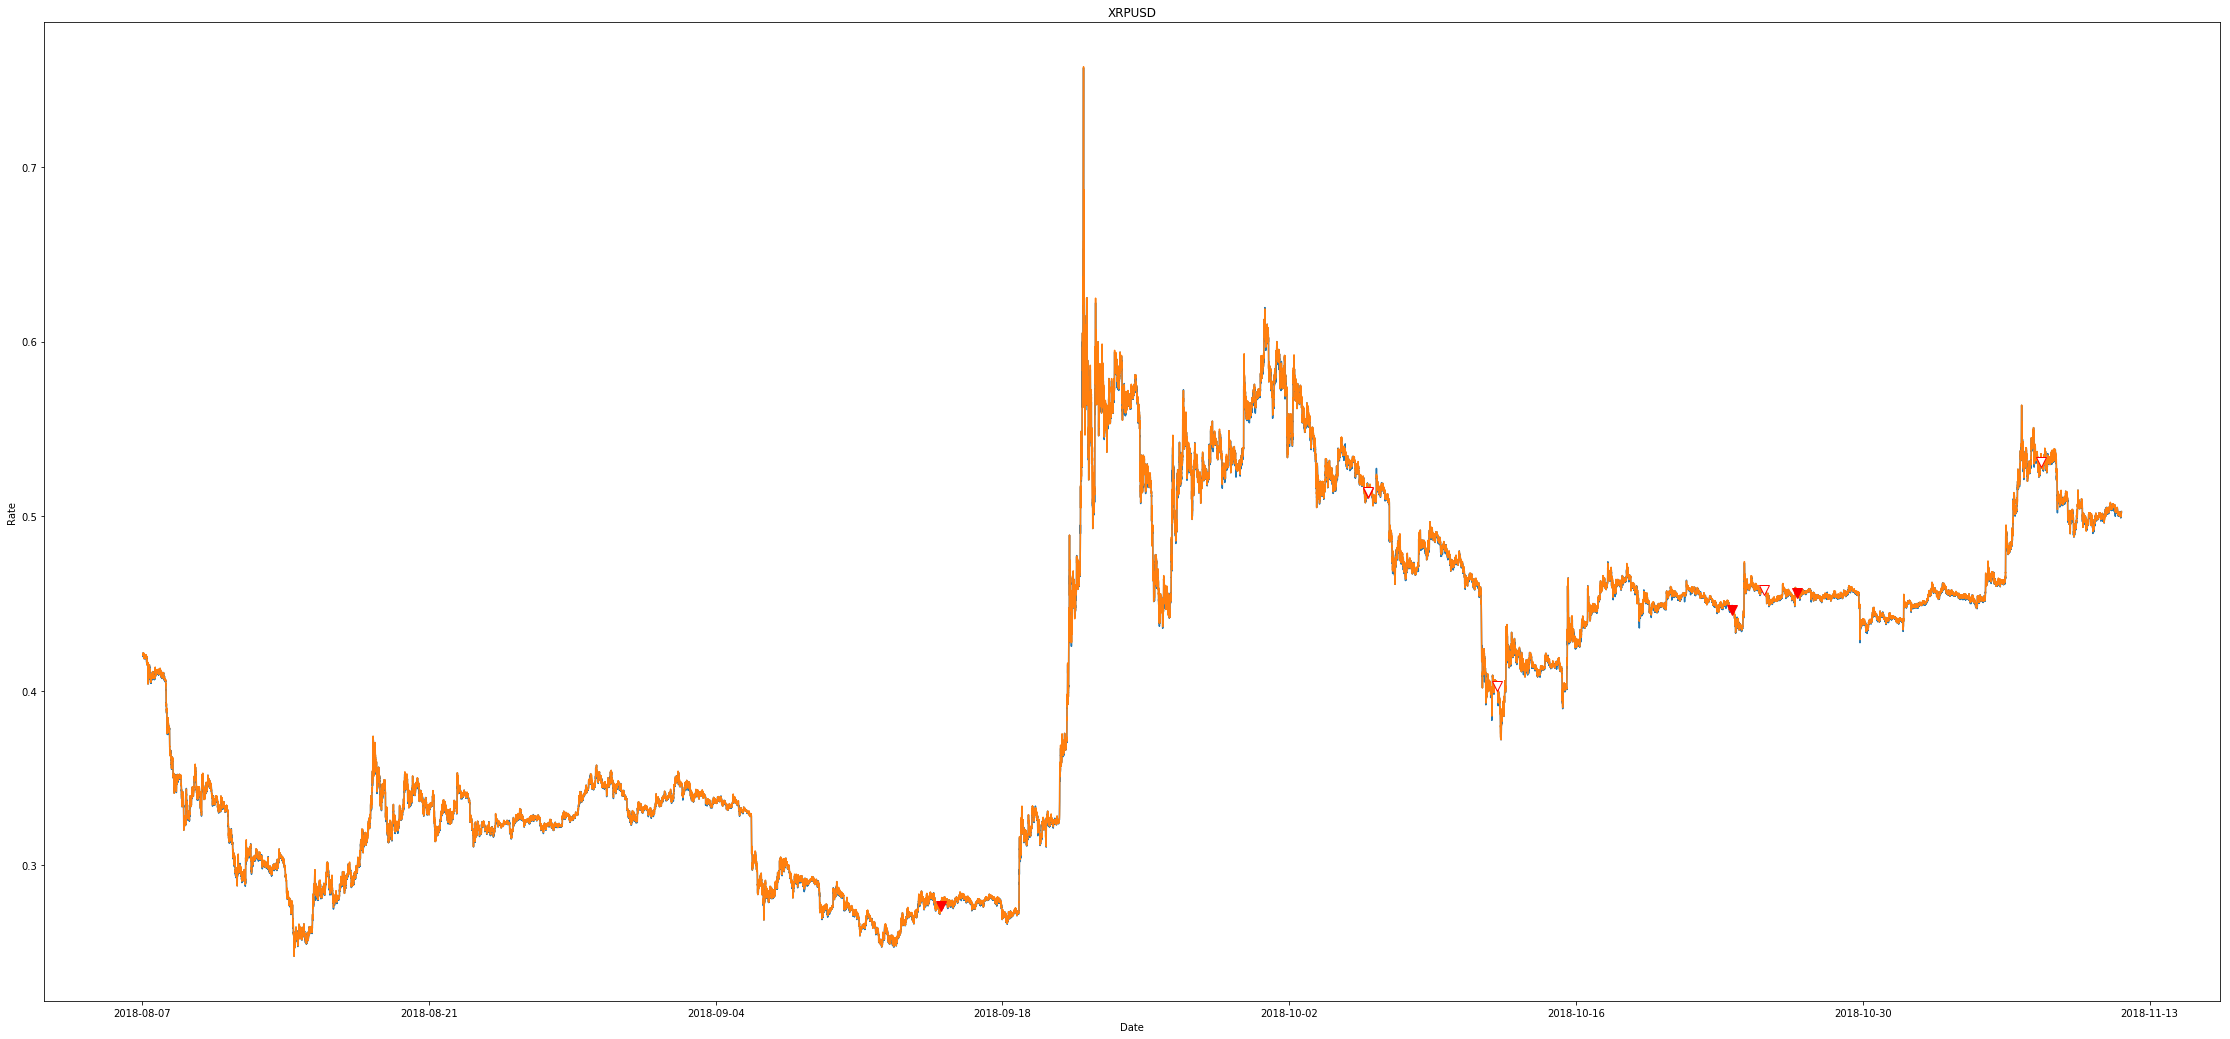

Activities:
   Product Position  Open Rate Close Rate        P&L
0   USDTRY    SHORT        6.6        5.5 35531647.4
1      HSI    SHORT    27175.0    26544.0    62900.0
2     CALL     LONG      767.8          0   -15456.6
3   XRPUSD    SHORT        0.3        0.5     -385.6
4      HSI    SHORT    26568.0    25758.0    80800.0
5     CALL     LONG      874.1      359.4   -10493.8
6   XRPUSD    SHORT        0.5        0.4     -113.8
7      HSI    SHORT    25570.0    24695.0    87300.0
8     CALL     LONG      773.6      131.3   -13044.2
9   XRPUSD    SHORT        0.4        0.5     -209.0
10     HSI    SHORT    24539.0    24776.0   -23900.0
11    CALL     LONG      579.7      774.0     3687.1
12  XRPUSD    SHORT        0.5        0.5     -258.9
13     HSI    SHORT    24740.0    24841.0   -10300.0
14    CALL     LONG      543.4          0   -11068.0
15     HSI    SHORT    26113.0    26130.0    -1900.0
16    CALL     LONG      844.0      828.5     -509.7
Summary:
Initial: 10000000 Final: 

In [11]:
# Export Portfolio
portfolio, tradelog = platform.exporttrades()
temp_log = tradelog
for i in range(len(temp_log)): 
    temp_log.loc[i, 'P&L'] = temp_log.loc[i, 'Unrealized P&L'] + temp_log.loc[i, 'Realized P&L']
print ('Activities:')
print (tradelog[['Product', 'Position', 'Open Rate', 'Close Rate', 'P&L']])
print ('Summary:')
print ('Initial:', round(portfolio['initial']), 'Final:', round(portfolio['cash']), 'P&L%:', round(portfolio['P&L'] * 100))